In [27]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

In [28]:
from skforecast.plot import plot_residuals

In [29]:
df = pd.read_csv("df_final.csv")

In [30]:
df

,Unnamed: 0,index,date,Encoded Products,Cadereyta total $,Cadereyta ctdad,Coahuila total $,Coahuila ctdad,Durango total $,Durango ctdad,...,Queretaro total $,Queretaro ctdad,Reynosa total $,Reynosa ctdad,San Luis total $,San Luis ctdad,Total libre de impuestos,Ctdad Ordenada,Indefinido total $,Indefinido ctdad
0,0,4,2022-01-02,Producto 11,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18162.130,3.5,58623.600,10.5,NaN,NaN
1,31,35,2022-01-02,Producto 117,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,25646.075,3.5,NaN,NaN
2,30,34,2022-01-02,Producto 8,0.0,0.0,239569.015,10.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,447295.450,21.0,NaN,NaN
3,29,33,2022-01-02,Producto 16,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,53339.440,3.5,NaN,NaN
4,28,32,2022-01-02,Producto 79,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,65930.935,3.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30686,26437,4295,2023-12-31,Producto 273,0.0,0.0,46090.135,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,42490.770,7.0,132639.955,21.0,NaN,NaN
30687,26438,4296,2023-12-31,Producto 273,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,3979.745,3.5,NaN,NaN
30688,26439,4297,2023-12-31,Producto 1,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5126.135,3.5,10252.130,7.0,NaN,NaN
30689,26431,4289,2023-12-31,Producto 273,0.0,0.0,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,15082.095,3.5,NaN,NaN


# Se reformatean los datos

In [31]:


df = df.drop(columns=['Unnamed: 0',"index","Total libre de impuestos","Indefinido total $","Indefinido ctdad"])
df = df.rename(columns={"date":"Fecha","Encoded Products":"Producto"})
df['Fecha'] = pd.to_datetime(df['Fecha'], format="mixed")
df.columns = df.columns.str.replace("total $", "Precio por unidad")
df.columns = df.columns.str.replace("ctdad", "Cantidad")
def div(numerator, denominator):
  return lambda row: 0.0 if row[denominator] == 0 else float(row[numerator]/row[denominator])
for i in range(2, len(df.columns)-1,2):
    df[df.columns[i]] = df.apply(div(df.columns[i], df.columns[i+1]), axis=1)
df = df.drop(axis = 0, index = 10865)
df = df.set_index('Fecha')
df["Precio promedio"] = df.iloc[:,1::2].mean(axis=1)
#Decidir si hacerlo antes o despues de elegir variables
df["Dia"] = df.index.day
df["Mes"] = df.index.month


# Se crean variables exogenas para probar importancia

In [32]:
data = df[(df["Producto"] == "Producto 1")]["Ctdad Ordenada"].asfreq("D", fill_value=0)
exog_var = df[(df["Producto"] == "Producto 1")]["Precio promedio"].asfreq("D", method="ffill")
exog_var2 = df[(df["Producto"] == "Producto 1")]["Mes"].asfreq("D", method="pad")

exog_var2 = pd.get_dummies(exog_var2, prefix="Mes",dtype="float")

exog_var4 = pd.DataFrame([data.loc[:] >= 100]).T
exog_var4 = exog_var4.astype(float)
exog_var3 = df[(df["Producto"] == "Producto 1")]["Dia"].asfreq("D", method="pad")
exog_var3 = pd.DataFrame(exog_var3.index.day)
exog_var3.index = exog_var2.index
exog_var3.replace(to_replace=[13,14,15,16,17,18,28,29,30,31,1,2], value=1, inplace=True)
exog_var3.replace(to_replace=[3,4,5,6,7,8,9,10,11,12,19,20,21,22,23,24,25,26,27,28], value=0, inplace=True)


In [35]:
exog_X = pd.concat([exog_var, exog_var2], axis=1)

In [36]:
exog_X

,Precio promedio,Mes_1,Mes_2,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12
Fecha,,,,,,,,,,,,,
2022-01-02,616.658636,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-03,321.540682,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-04,109.806364,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-05,520.494545,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-06,238.180909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,439.245758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-12-28,401.030455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-12-29,269.152727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Se hacen las pruebas de estacionalidad y autocorrelacion

Train dates : 2022-01-02 00:00:00 --- 2023-11-01 00:00:00  (n=669)
Test dates  : 2023-11-01 00:00:00 --- 2023-12-31 00:00:00  (n=61)


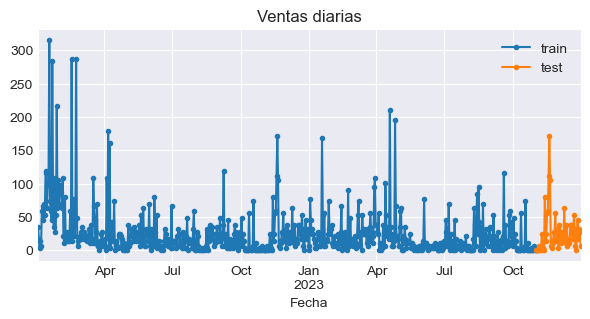

In [37]:
# Train-test dates
# ======================================================================================
end_train = '2023-11-01'
print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})")
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train',style='.-')
data_test.plot(ax=ax, label='test',style='.-')
ax.set_title('Ventas diarias')
ax.legend();

Test stationarity for original series
-------------------------------------
ADF Statistic: -5.894702105427544, p-value: 2.8696081751605103e-07
KPSS Statistic: 0.750800389234373, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -10.969857875304026, p-value: 7.930739077703269e-20
KPSS Statistic: 0.06153348909941545, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -12.866912976250633, p-value: 4.972731516755039e-24
KPSS Statistic: 0.023594874669801286, p-value: 0.1


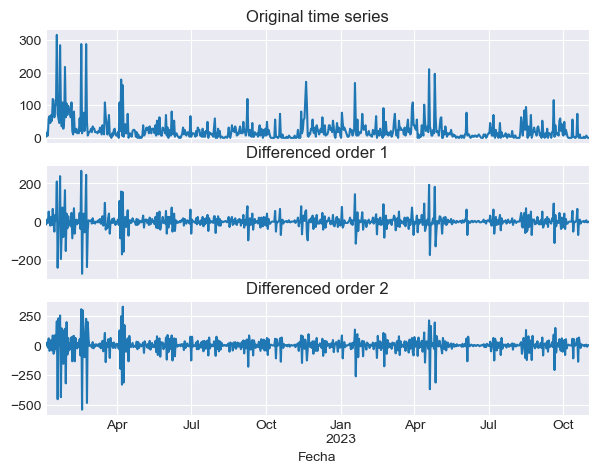

In [38]:
# Test stationarity
# ==============================================================================
warnings.filterwarnings("ignore")

data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data)
kpss_result = kpss(data)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

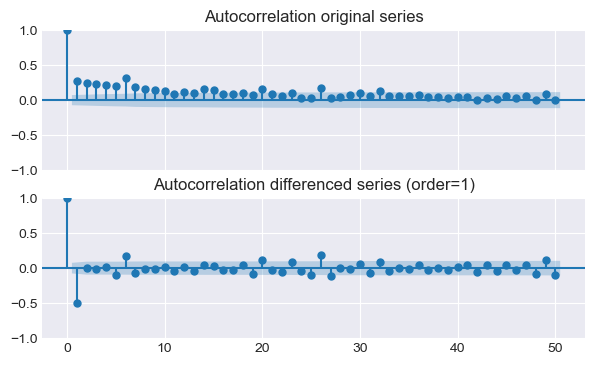

In [39]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');

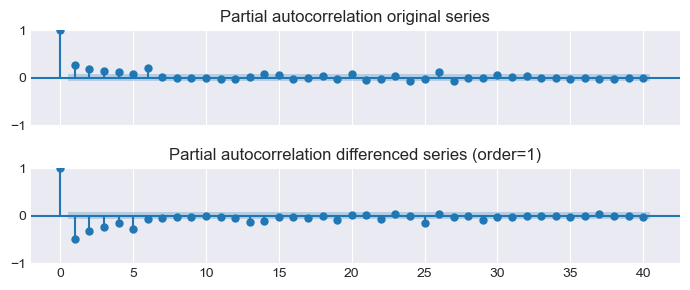

In [40]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=40, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=40, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

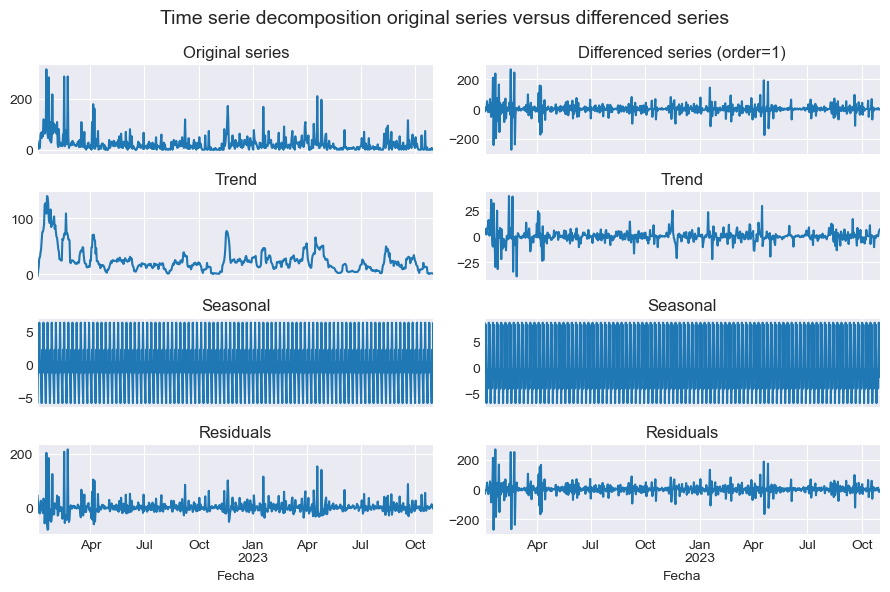

In [41]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

Se usa un mes y medio de validación y 17 días de test

Train dates      : 2022-01-02 00:00:00 --- 2023-11-01 00:00:00  (n=669)
Validation dates : 2023-11-01 00:00:00 --- 2023-12-15 00:00:00  (n=45)
Test dates       : 2023-12-15 00:00:00 --- 2023-12-31 00:00:00  (n=17)


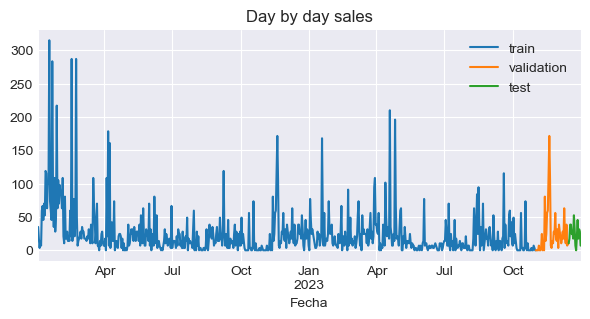

In [42]:
# Train-validation-test data
# ======================================================================================
end_train = '2023-11-01'
end_val = '2023-12-15'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  "
    f"(n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_val:])})"
)

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.set_title('Day by day sales')
ax.legend();

# Se buscan los mejores valores de arima con auto-arima

In [43]:
# Auto arima: selection base on AIC
# ==============================================================================
model = auto_arima(
            y                 = data.loc[:end_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            exog = exog_X.loc[:end_val],
            m                 = 12, # Seasonal period
            d                 = None, # The algorithm will determine 'd'
            D                 = None, # The algorithm will determine 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=7111.925, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7122.085, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=7064.542, Time=0.80 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7078.359, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7402.531, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=7066.476, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=7066.522, Time=1.65 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=7060.531, Time=1.15 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=7064.478, Time=0.55 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7068.479, Time=1.54 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=7066.356, Time=1.50 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept

## Se checa el modelo con los datos de validación

In [49]:
# Backtest predictions with the best model according to grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 0, 0), seasonal_order=(1, 0, 1, 12), maxiter=500),
             )

metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                exog = exog_X,
                                metric                = 'mean_squared_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Backtest predictions with the best model according to auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 0, 1), seasonal_order=(0, 0,0, 12), maxiter=500),
             )

metric_m2, predictions_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = data,
                                initial_train_size    = len(data.loc[:end_val]),
                                steps                 = 12,
                                exog = exog_X,
                                metric                = 'mean_absolute_percentage_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


# Se hace la predicción con los datos de test y se plotean
# NO SE PORQUE esta dando un MAPE de ese número, antes estaba en 0.44 y no le moví nada :( si alguien me puede ayudar para calcularlo manual (o con codigo), me ayudaria mucho

Metric (mean_absolute_error) for grid search model: 193.0601371923745
Metric (mean_absolute_percentage_error) for auto arima model : 4419058475189035.0


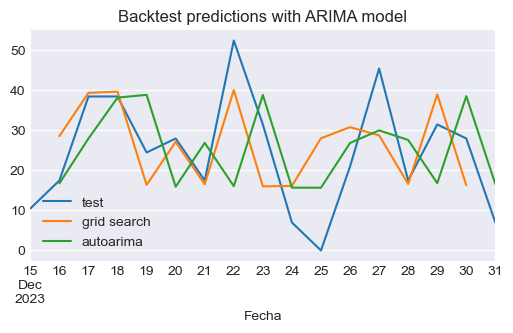

In [50]:
# Compare predictions
# ==============================================================================
print(f"Metric (mean_absolute_error) for grid search model: {metric_m1}")
print(f"Metric (mean_absolute_percentage_error) for auto arima model : {metric_m2}")

fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_val:].plot(ax=ax, label='test')
predictions_m1 = predictions_m1.shift(-1).rename(columns={'pred': 'grid search'})
predictions_m2 = predictions_m2.rename(columns={'pred': 'autoarima'})
predictions_m1.plot(ax=ax)
predictions_m2.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

In [47]:
# Predict all the months of 2024 and plot residuals

# Forecaster
forecaster.fit(y=data.loc[:end_train], exog=exog_X.loc[:end_train])

In [ ]:
forecaster.get_feature_importances()

,feature,importance
0,Precio promedio,0.074491
1,Mes_1,22.692453
2,Mes_2,3.173554
3,Mes_3,1.805520
4,Mes_4,4.822669
5,Mes_5,-5.579933
6,Mes_6,-8.490810
7,Mes_7,-6.624921
8,Mes_8,-6.449459
9,Mes_9,-5.783730


Ya puestas las predicciones no puede ser un mape tan alto

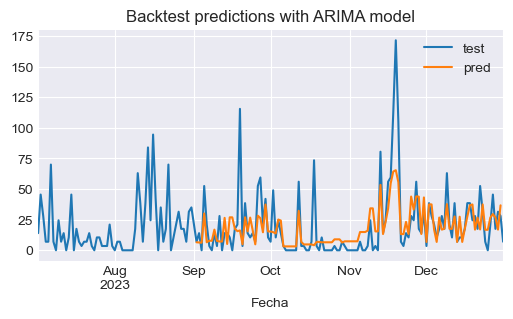

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
data.loc["2023-07-02":].plot(ax=ax, label='test')
predictions_m1 = predictions_m3
predictions_m1.plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

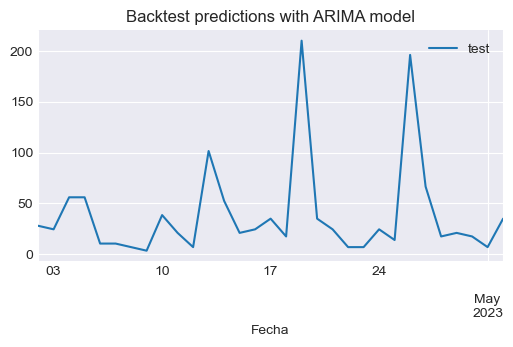

In [ ]:
#plot every month and put a point in each data point
fig, ax = plt.subplots(figsize=(6, 3))
data.loc["2023-4-02":"2023-5-02"].plot(ax=ax, label='test')
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

In [ ]:
residuals = data.loc["2023-09-02":] - predictions_m1

In [ ]:
data.loc["2023-12-16":] 

Fecha
2023-12-16    17.5
2023-12-17    38.5
2023-12-18    38.5
2023-12-19    24.5
2023-12-20    28.0
2023-12-21    17.5
2023-12-22    52.5
2023-12-23    31.5
2023-12-24     7.0
2023-12-25     0.0
2023-12-26    21.0
2023-12-27    45.5
2023-12-28    17.5
2023-12-29    31.5
2023-12-30    28.0
2023-12-31     7.0
Freq: D, Name: Ctdad Ordenada, dtype: float64

In [ ]:
residuals

2023-09-02     0.472308
2023-09-03     7.622297
2023-09-04    -6.203303
2023-09-05    22.411883
2023-09-06    14.442057
                ...    
2023-12-27    15.928839
2023-12-28    -9.224457
2023-12-29    14.599275
2023-12-30    -8.713491
2023-12-31          NaN
Freq: D, Length: 121, dtype: float64

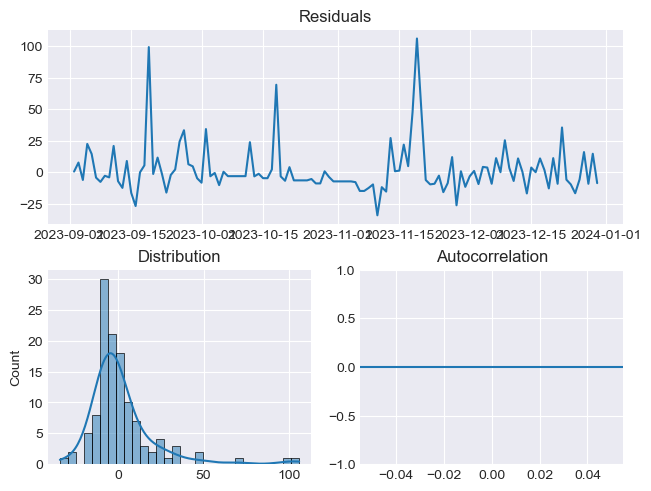

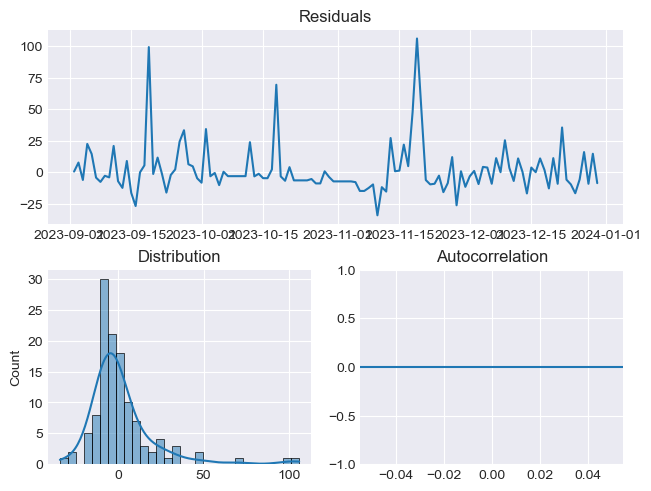

In [ ]:
plot_residuals(residuals)